<h1>Data Analysis</h1>
<h2>Data Generation</h2>
This page is for analysis of the data and analysis of the model. First, we'll look at the distributions of the different components of data generation. First, we'll load the imports and Data Generator before we plot the linear movement we're creating through the data generating process.  

In [18]:
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.distributions.util import gather
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
import numpy as np
import enum

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

assert pyro.__version__.startswith('1.7.0')

class MovementType(enum.Enum):
    Sinusoidal = 1
    Linear2D = 2
    Linear3D = 3

class Args:
    def __init__(self):
        self.args = self.get_default_args()

    def get_default_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1.
        self.emission_prob = 0.8
        self.emission_noise_scale = 0.1 
        assert self.max_num_objects >= self.expected_num_objects
        return self 

    def get_prior_predictive_checks_args(self):
        self.num_frames = 5
        self.expected_num_objects = int(dist.Uniform(1, 5).sample())
        self.expected_num_spurious = float(int(dist.Uniform(1,3).sample()))
        self.max_num_objects = int(self.expected_num_objects + self.expected_num_spurious)
        self.emission_prob = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 3.)/4.))) #aiming for between [0.5,1.0]
        self.emission_noise_scale = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 2.)/4.))) #aiming for between [0.0,0.5]
        assert self.max_num_objects >= self.expected_num_objects
        print("Predictive check args. Num objects: ", self.expected_num_objects, " Num spurious: ", self.expected_num_spurious)
        print("Emission prob: ", self.emission_prob, " Noise scale: ", self.emission_noise_scale)
        return self


class DataGenerator:
    def __init__(self, movementType):
        print("Initializing DataGenerator with movement type ", movementType)
        self.movementType = movementType
        if self.movementType == MovementType.Sinusoidal:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear2D:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear3D:
            self.numDimensions = 3
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

    def get_dynamics(self, num_frames):
        if self.movementType == MovementType.Sinusoidal:
            time = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([time.cos(), time.sin()], -1)
        elif self.movementType == MovementType.Linear2D:
            x = torch.arange(float(num_frames)) / (num_frames - 1)
            y = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([x, y], -1)
        elif self.movementType == MovementType.Linear3D:
            x = torch.arange(float(num_frames)) / (num_frames - 1)
            y = torch.arange(float(num_frames)) / (num_frames - 1)
            z = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([x, y, z], -1)
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

        return dynamics

<h3>Single Linear Track</h3>


Initializing DataGenerator with movement type  MovementType.Linear2D
torch.Size([50, 1])
torch.Size([50, 1])
torch.Size([100, 1])
tensor([[-1.8516,  0.1807]])


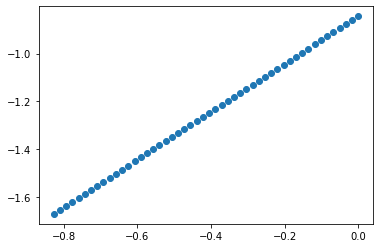

In [19]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_frames = 100
args.expected_num_objects = 1
args.max_num_objects = 2

#assume linear 2D motion
num_dimensions = 2
dataGenerator = DataGenerator(MovementType.Linear2D)
num_objects = int(round(args.expected_num_objects))  
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
dynamics = dataGenerator.get_dynamics(args.num_frames)
positions = dynamics.mm(states.t())

x = positions[:50]
y = positions[50:]
print(y.shape)
print(x.shape)
print(positions.shape)
print(states)

plt.scatter(x,y)

<h3>Multiple Linear Tracks</h3>
Now that the single layer looks right, we will next look at multiple objects' projections plotted. This shows that any trajectory with the offset we're using still passes through the center (0,0). If we wanted we could add an additional offset, as there will be association confusion when passing through the center. 

Initializing DataGenerator with movement type  MovementType.Linear2D
torch.Size([50, 80])
torch.Size([50, 80])
torch.Size([100, 80])


Text(0.5, 1.0, 'No offset')

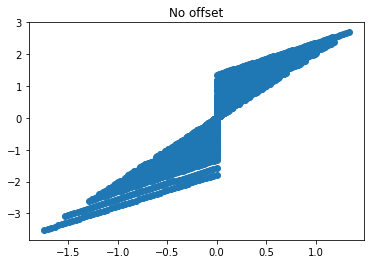

In [20]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_frames = 100
args.expected_num_objects = 80
args.max_num_objects = 101

#assume linear 2D motion
num_dimensions = 2
dataGenerator = DataGenerator(MovementType.Linear2D)
num_objects = int(round(args.expected_num_objects))  
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
dynamics = dataGenerator.get_dynamics(args.num_frames)
positions = dynamics.mm(states.t())

x = positions[:50]
y = positions[50:]
print(y.shape)
print(x.shape)
print(positions.shape)
#print(states)

plt.scatter(x,y,cmap='jet')
plt.title("No offset")

Now I add an offset, and I'll plot a few lines so we can see them over the distribution.

torch.Size([100, 80])
torch.Size([80, 1])


Text(0.5, 1.0, 'With offset')

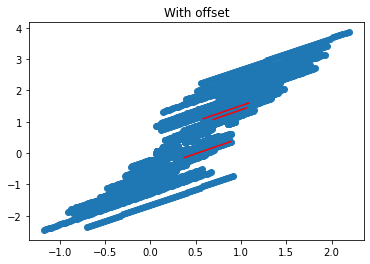

In [21]:
offsets = dist.Uniform(0., 1.).sample((args.expected_num_objects,1))
dynamics = dataGenerator.get_dynamics(args.num_frames)
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
positions = dynamics.mm(states.t())
positions = positions + offsets.t()

print(positions.shape)
print(offsets.shape)

x = positions[:50]
y = positions[50:]


plt.scatter(x,y,cmap='jet')
plt.plot(x[:,0],y[:,0],c='r')
plt.plot(x[:,30],y[:,30],c='r')
plt.plot(x[:,50],y[:,50],c='r')
plt.title("With offset")

X and Y states need to be separated, though this is out of scope for this project. 

<h2>Prior Predictive Checks</h2>

To do prior predictive checks I needed to remove the "observations" or the data from the model to be able to check if the model performs acceptably without data. 

To do this, I needed to still have the num_observed, which relies on is_observed which relies on the observations variable. So, I created new variables using the following distributions, which represents a similar method the data would be generated by:

spurious- Poisson

emitted- Bernoulli

is_observed is then obtained from emitted, which is a combination of the Bernoulli distribution of expected observations over a number of frames + spurious observations over a number of frames

Because I need to know the max number of objects, I had to switch the time and the max number of objects plates, which then required reversing dimensions

In [22]:
def model(args, verbose=False):
   
    with pyro.plate("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                            dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        with poutine.mask(mask=exists.bool()):
            states = pyro.sample("states", dist.Normal(0., 1.).expand([args.num_dimensions]).to_event(1))
            positions = dataGenerator.get_dynamics(args.num_frames).mm(states.t())
    if verbose:
        print("Positions shapes: ", positions.shape)
    positions = torch.transpose(positions,0,1)
    
    with pyro.plate("time", args.num_frames):
        spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,1))
        maxSpurious = int(max(spurious)[0])
        args.max_num_objects = int(args.expected_num_objects + maxSpurious)
        if verbose:
            print("Max number of objects: ", args.max_num_objects)
        with pyro.plate("detections", args.max_num_objects):
            emitted = dist.Bernoulli(args.emission_prob).sample((int(args.expected_num_objects), int(args.num_frames)))
            spuriousVec = np.zeros((maxSpurious, args.num_frames))
            
            #assign 1 or observed for the number of spurious observations per frame
            count = 0
            for i in spurious:
                spuriousVec[0:int(i[0]), count] = 1
                count = count + 1
                
            if verbose:
                print("Emitted shape before: ", emitted.shape)
                print(emitted)
            
            #combine the emitted with the spurious observations
            emitted = torch.cat((emitted,torch.tensor(spuriousVec)))
            if verbose:
                print("Emitted shape after: ", emitted.shape)
                print(emitted)

            #add assignment IDs for each of the observations
            is_observed = (emitted > 0)
            if verbose:
                print("Max number of objects: ", args.max_num_objects)
                print("is_observed shape: ", is_observed.shape)
                print(is_observed)
            with poutine.mask(mask=is_observed):
                assign = pyro.sample("assign",
                                    dist.Categorical(torch.ones(args.max_num_objects)))
            
            if verbose:
                print("Assign:", assign.shape, assign)
            is_spurious = np.zeros(emitted.shape, dtype=bool)
            is_spurious[int(args.expected_num_objects):,:] = (spuriousVec).astype(bool)
            is_spurious = torch.tensor(is_spurious)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)

            bernoulliRealProbs = args.expected_num_objects / num_observed
            bernoulliRealProbs = np.clip(bernoulliRealProbs, 0., 1.)
            if verbose:
                print("bernouli probs: ", bernoulliRealProbs, " num_observed: ", num_observed)
            isReal = pyro.sample("is_real",
                        dist.Bernoulli(bernoulliRealProbs))

            bernoulliSpuriousProbs = args.expected_num_spurious / num_observed
            bernoulliSpuriousProbs = np.clip(bernoulliSpuriousProbs, 0., 1.)
            isSpurious = pyro.sample("is_spurious",
                        dist.Bernoulli(bernoulliSpuriousProbs))

            # The remaining continuous part is exact.
            with poutine.mask(mask=is_real):
                bogus_position = positions.new_zeros(maxSpurious-1, args.num_frames)
                if verbose:
                    print("Bogus shape: ", bogus_position.shape, " assign shape: ", assign.shape, "position shape: ", positions.shape)
                augmented_positions = torch.cat([positions, bogus_position], 0)
                if verbose:
                    print("Augmented shape: ", augmented_positions.shape)
                augmented_positions = torch.transpose(augmented_positions,0,1)
                assign = torch.transpose(assign,0,1)
                predicted_positions = gather(augmented_positions, assign, -1)
                predicted_positions = torch.transpose(predicted_positions,0,1)
                real = pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale))
                real = torch.transpose(real, 0, 1)
            with poutine.mask(mask=is_spurious):
                spurious = pyro.sample("spurious_observations", dist.Normal(0., 1.))
            return isReal, isSpurious, real, spurious

In [91]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2
isReal, isSpurious, real_observations, spurious_observations = model(args)
print("Is Real Mask: ")
print(isReal)
print("Is Spurious Mask: ")
print(isSpurious)
print("Real Observations: ")
print(real_observations)
print("Spurious Observations: ")
print(spurious_observations)


Is Real Mask: 
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
Is Spurious Mask: 
tensor([[0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Real Observations: 
tensor([[ 0.0702, -0.0465,  0.0426, -0.1004],
        [-0.6149, -0.6481, -0.6953, -0.5345],
        [ 0.4495,  0.3325,  0.4644,  0.4727],
        [-1.6223, -1.6782, -1.8404, -1.8419],
        [ 1.0869,  0.8880,  1.0499,  0.8672]])
Spurious Observations: 
tensor([[-0.1609,  0.1757,  0.0505,  1.1264, -0.2167],
        [ 0.2790,  2.2037,  1.1136, -0.6297,  0.4114],
        [-0.0355,  1.7897, -1.3323,  1.2298, -1.2459],
        [-0.4177,  0.6500,  1.1474, -1.8490,  0.9142]])


In [86]:
from scipy.stats import norm

# For the binary "Real" and "Spurious" masks returns a vector of ratios that are real or spurious for each sample
# For the normalized "Real" and "Spurious" likelihoods returns a vector of all scenarios concatted together
# These can be used to acquire a mean and stddev and be plotted to see the distributions
def getManySamples(args, number_of_samples):
    numReal = []
    numRealStddev = []
    numSpurious = []
    numSpuriousStddev = []

    allPositionsReal = torch.tensor([])
    allPositionsSpurious = torch.tensor([])

    for i in range(number_of_samples):
        isReal, isSpurious, real_observations, spurious_observations = model(args)

        #add ratio of real and spurious
        #numReal.append(torch.sum(isReal)/torch.numel(isReal))
        numReal.append(np.array(isReal))
        numRealStddev.append(torch.std(isReal))
        #numSpurious.append(torch.sum(isSpurious)/torch.numel(isSpurious))
        numSpurious.append(np.array(isSpurious))
        numSpuriousStddev.append(torch.std(isSpurious))

        #Accumulating all percentages from all samples so we can compute a mean and stddev
        allPositionsReal = torch.cat((allPositionsReal, real_observations),1)
        allPositionsSpurious = torch.cat((allPositionsSpurious, spurious_observations),1)

    numReal = np.array(numReal).flatten()
    numSpurious = np.array(numSpurious).flatten()
    print("Min real position: ", min(numReal), " Max real position: ", max(numReal))
    print("Min spurious position: ", min(numSpurious), " Max spurious position: ", max(numSpurious))
    print("Average positions per frame: ", (torch.sum(allPositionsReal)/args.num_frames)/number_of_samples)
    print("Average number of spurious returns: ", (torch.sum(allPositionsSpurious)/args.num_frames)/number_of_samples)
    return numReal, numRealStddev, numSpurious, numSpuriousStddev, allPositionsReal, allPositionsSpurious

def getStatsAndPlotCount(numReal, realStddev, numSpurious, spuriousStddev, ax, args, emissionColor, spuriousColor, label=False):
    numRealMean = np.mean(numReal)
    numRealStddev = np.std(numReal)
    if numRealStddev == 0:
        numRealStddev = float(realStddev[0])
    print("Num real mean: ", numRealMean, " stddev: ", numRealStddev)

    x = np.linspace(min(numReal), max(numReal), 100)
    ax[0].plot(x, norm.pdf(x, numRealMean, numRealStddev), c=emissionColor)

    numSpuriousMean = np.mean(np.array(numSpurious))
    numSpuriousStddev = np.std(np.array(numSpurious))
    if numSpuriousStddev == 0:
        numSpuriousStddev = float(spuriousStddev[0])
    print("Num real mean: ", numSpuriousMean, " stddev: ", numSpuriousStddev)

    x2 = np.linspace(min(numSpurious), max(numSpurious), 100)
    ax[0].plot(x2, norm.pdf(x2, numSpuriousMean, numSpuriousStddev), c=spuriousColor)
    
    return numRealMean, numRealStddev, numSpuriousMean, numSpuriousStddev

def getStatsAndPlotPositions(allPositionsReal, allPositionsSpurious, ax, args, emissionColor, spuriousColor, label=False):
    realSum = torch.sum(allPositionsReal)
    realMean = realSum/torch.numel(allPositionsReal)
    #realStddev = np.std(realSum)
    realStddev = 0.4

    realTitle = "Real, emissionProb: " + str(args.emission_prob) + " with color " + emissionColor
    print(realTitle)
    if label:
        ax[1].plot(allPositionsReal, c=emissionColor, label=realTitle)
    else:
        ax[1].plot(allPositionsReal, c=emissionColor)

    spuriousSum = torch.sum(allPositionsSpurious)
    spuriousMean = spuriousSum/torch.numel(allPositionsSpurious)
    #spuriousStddev = np.std(spuriousSum)
    spuriousStddev = 0.7

    spuriousTitle = "Spurious, expected: " + str(args.expected_num_spurious) + " with color " + spuriousColor
    print(spuriousTitle)
    if label:
        ax[1].plot(allPositionsSpurious, c=spuriousColor, label=spuriousTitle)
    else:
        ax[1].plot(allPositionsSpurious, c=spuriousColor)
    return realMean, realStddev, spuriousMean, spuriousStddev


In [65]:

def runPriorPredictiveChecks(args, ax, emissionColor, spuriousColor, label=False):
    print("Running variation with: ")
    print("Emission Probability: ", args.emission_prob)
    print("Expected Number of Spurious: ", args.expected_num_spurious)
    numReal, numRealStddev, numSpurious, numSpuriousStddev, allPositionsReal, allPositionsSpurious = getManySamples(args, 1)
    getStatsAndPlotCount(numReal, numRealStddev, numSpurious, numSpuriousStddev, ax, args, emissionColor, spuriousColor, label)
    getStatsAndPlotPositions(allPositionsReal, allPositionsSpurious, ax, args,  emissionColor, spuriousColor, label)
   

Here we will run to get the mean and stddev of the real and spurious targets, as well as plot their positions. We see that real has a higher mean as expected, and the real objects are more linear and closer together, where the spurious is much more chaotic, as expected

Running variation with: 
Emission Probability:  0.8
Expected Number of Spurious:  1.0
Min real position:  0.0  Max real position:  1.0
Min spurious position:  0.0  Max spurious position:  1.0
Average positions per frame:  tensor(-0.1088)
Average number of spurious returns:  tensor(0.7160)
Num real mean:  0.85714287  stddev:  0.34992707
Num real mean:  0.34285715  stddev:  0.4746642
Real, emissionProb: 0.8 with color g
Spurious, expected: 1.0 with color r


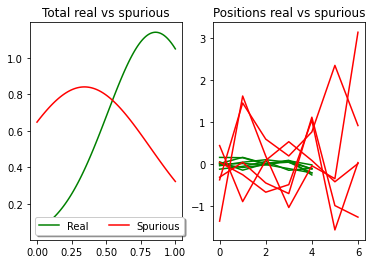

In [66]:
#Run single prior predictive check
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2   

#set up plotting
fig, ax = plt.subplots(1,2)
ax[0].set_title('Total real vs spurious')
ax[1].set_title('Positions real vs spurious')

#run default arguments
runPriorPredictiveChecks(args, ax, 'g', 'r')
ax[0].legend(['Real', 'Spurious'], shadow=True, fancybox=True, ncol=2)
#ax[1].legend(['Real', 'Spurious'], shadow=True, fancybox=True, ncol=2)
plt.show()

Running emission:  0.4  and spurious:  0.0
Running variation with: 
Emission Probability:  0.4
Expected Number of Spurious:  0.0
Running emission:  0.4  and spurious:  1.0
Running variation with: 
Emission Probability:  0.4
Expected Number of Spurious:  1.0
Min real position:  0.0  Max real position:  1.0
Min spurious position:  0.0  Max spurious position:  1.0
Average positions per frame:  tensor(0.7419)
Average number of spurious returns:  tensor(-0.2305)
Num real mean:  0.96  stddev:  0.19595918
Num real mean:  0.68  stddev:  0.46647614
Real, emissionProb: 0.4 with color g
Spurious, expected: 1.0 with color k
Running emission:  0.4  and spurious:  2.0
Running variation with: 
Emission Probability:  0.4
Expected Number of Spurious:  2.0
Running emission:  0.6  and spurious:  0.0
Running variation with: 
Emission Probability:  0.6
Expected Number of Spurious:  0.0
Running emission:  0.6  and spurious:  1.0
Running variation with: 
Emission Probability:  0.6
Expected Number of Spurious

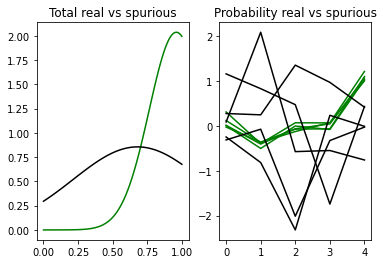

In [43]:
#run the variation changing the emission probability and the expected number of spurious observations
emissionProbs = [0.4, 0.6, 0.8, 1.0]
expectedSpurious = [0., 1., 2.]

emissionColors = ['g', 'b', 'r', 'o']
spuriousColors = ['k', 'c', 'y']

#set up plotting
fig, ax = plt.subplots(1,2)
ax[0].set_title('Total real vs spurious')
ax[1].set_title('Probability real vs spurious')

#setting initial args, but we'll be overwriting two of them through the loop
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2

#runPriorPredictiveChecks(args, ax, emissionColors[3], spuriousColors[2])

emCount = 0
spCount = 0
for em in emissionProbs:
    args.emission_prob = em
    emColor = emissionColors[emCount]
    for sp in expectedSpurious:
        spColor = spuriousColors[spCount]
        args.expected_num_spurious = sp
        try:
            print("Running emission: ", em, " and spurious: ", sp)
            runPriorPredictiveChecks(args, ax, emColor, spColor)
        except:
            #print("Didn't work for emission: ", em, " and spurious: ", sp)
            continue
        spCount = spCount + 1
    emCount = emCount + 1

#ax[0].legend(['Real', 'Spurious'], shadow=True, fancybox=True)
#ax[1].legend(['Real', 'Spurious'], shadow=True, fancybox=True)
plt.show()

In [94]:
def runSamplesOnPriorChecks(args, ax, emissionColor, spuriousColor, label=False):
    numReal, numRealStddev, numSpurious, numSpuriousStddev, allPositionsReal, allPositionsSpurious = getManySamples(args, 1)
    
    numRealMean, numRealStddev, numSpuriousMean, numSpuriousStddev = getStatsAndPlotCount(numReal, numRealStddev, numSpurious, numSpuriousStddev, ax, args, emissionColor, spuriousColor, label)
    realMean, realStddev, spuriousMean, spuriousStddev = getStatsAndPlotPositions(allPositionsReal, allPositionsSpurious, ax, args,  emissionColor, spuriousColor, label)
    ax[0].legend(['Real', 'Spurious'], shadow=True, fancybox=True, ncol=2)
    plt.show()
    
    numRealTally = []
    numSpuriousTally = []
    #make samples from the means produces by the mean obtained by the prior check
    #start with plotting for number of real vs spurious
    for i in range(100):
        numberOfRealObservations = 100 * (dist.Normal(numRealMean, numRealStddev).sample())
        #print("Real sampled: ", numberOfRealObservations)
        numRealTally.append(int(numberOfRealObservations))
        numberOfSpuriousObservations = 100 * (dist.Normal(numSpuriousMean, numSpuriousStddev).sample())
        #print("Spurious sampled: ", numberOfSpuriousObservations)
        numSpuriousTally.append(int(numberOfSpuriousObservations))
        
    numRealTally = np.array(numRealTally)
    numSpuriousTally = np.array(numSpuriousTally)
    
    plt.hist(numRealTally, bins = (max(numRealTally)-min(numRealTally) + 1))
    plt.xlim(-100,200)
    plt.ylim(0,10)
    plt.title("Real samples from mean and stddev")
    plt.show()
    plt.hist(numSpuriousTally, bins = (max(numSpuriousTally)-min(numSpuriousTally) + 1))
    plt.xlim(-100,200)
    plt.ylim(0,10)
    plt.title("Spurious samples from mean and stddev")
    plt.show()
    

Min real position:  0.0  Max real position:  1.0
Min spurious position:  0.0  Max spurious position:  1.0
Average positions per frame:  tensor(-2.2380)
Average number of spurious returns:  tensor(0.4227)
Num real mean:  0.88  stddev:  0.32496154
Num real mean:  0.24  stddev:  0.42708316
Real, emissionProb: 0.8 with color g
Spurious, expected: 1.0 with color r


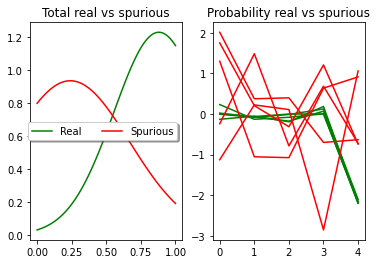

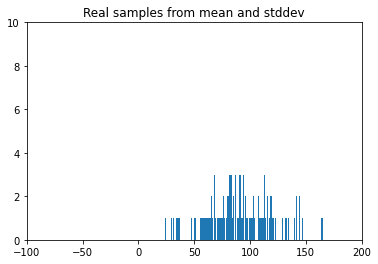

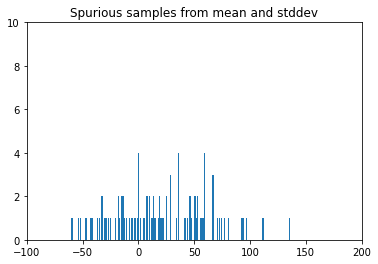

In [95]:
#set up plotting
fig, ax = plt.subplots(1,2)
ax[0].set_title('Total real vs spurious')
ax[1].set_title('Probability real vs spurious')

#setting initial args, but we'll be overwriting two of them through the loop
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2

runSamplesOnPriorChecks(args, ax, 'g', 'r')